In [99]:
import pandas as pd
import openai
from dotenv import load_dotenv
import os
import re

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")
pd.set_option('display.max_colwidth', None)

def extract_answer_tag(text: str) -> str:
    answer_match = re.search(r'<answer>(.*?)</answer>', text, re.DOTALL)
    answer_content = answer_match.group(1) if answer_match else None
    return answer_content

In [100]:
SQL_EVALUATION_PROMPT = """
You are a SQL expert. You are given a SQL query and a expected answer.
You need to evaluate if the SQL query is correct and if it answers the question.
You need to return a boolean value.
"""

SQL_CORRECTNESS_PROMPT = """
You are a SQL expert. You are given 2 results from a SQL query. One corresponds to the
gold query results, which are meant to be the truth. The other corresponds to another
query results.
You need to evaluate if the results from this other query is correct, meaning, if they
output the same results in terms of content. Even if they differ by commas, parenthesis
or other characters, you need to evaluate the actual content.
You need to return a boolean value.
"""


def call_gpt_api_to_check_query(sql_query, expected_answer, model="gpt-3.5-turbo"):
    prompt = """
    SQL query: {sql_query}
    Expected answer: {expected_answer}

    Return only the boolean value. In enclosed tags like <answer>true</answer> or <answer>false</answer>.
    """
    prompt = prompt.format(sql_query=sql_query, expected_answer=expected_answer)
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SQL_EVALUATION_PROMPT},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

def call_gpt_api_to_check_query_answer(sql_query_results, expected_query_answer, model="gpt-3.5-turbo"):
    prompt = """
    SQL query results: {sql_query}
    Gold query answer: {expected_answer}

    Return only the boolean value. In enclosed tags like <answer>true</answer> or <answer>false</answer>.
    """
    prompt = prompt.format(sql_query=sql_query_results, expected_answer=expected_query_answer)
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SQL_CORRECTNESS_PROMPT},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

In [101]:
test_type = 'students-exercise'

In [102]:
df = pd.read_csv(f'{test_type}/test_file_results.csv')

df.head()

,question,expected_query,llm_query,llm_executed_query_results,expected_query_results
0,Encontre o nome de todos os Juniores (nível = JR) que estão matriculados em um curso ministrado por Ivana Teach.,"select A.nomeAluno\nfrom Aluno as A, Curso as C, Professor as P, Matriculado as M\nwhere A.nivel='JR'\nand P.nomeProf = 'Ivana Teach'\nand C.idProf = P.idProf\nand M.nomeCurso = C.nome\nand M.nroAluno = A.nroAluno;",\nSELECT DISTINCT a.nomealuno \nFROM aluno a \nJOIN matriculado m ON a.nroaluno = m.nroaluno \nJOIN curso c ON m.nomecurso = c.nome \nJOIN professor p ON c.idprof = p.idprof \nWHERE a.nivel = 'JR' \n AND p.nomeprof = 'Ivana Teach'; \n,"Christopher Garcia, Paul Hall","Christopher Garcia, Paul Hall"
1,Encontre o nome do aluno mais velho que é formado em History ou matriculado em um curso ministrado pelo Ivana Teach.,"select nomeAluno\nfrom Aluno\nwhere formacao = 'History'\nor nroAluno in (\nselect A2.nroALuno\nfrom Aluno as A2, Curso as C, Professor as P, Matriculado as M\nwhere P.nomeProf = 'Ivana Teach'\nand C.idProf = P.idProf\nand M.nomeCurso = C.nome\nand M.nroAluno = A2.nroAluno)\nand idade >= all (\nselect A1.idade\nfrom Aluno as A1\nwhere A1.formacao = 'History' or\n A1.nroAluno in (\nselect A2.nroALuno\nfrom Aluno as A2, Curso as C, Professor as P, Matriculado as M\nwhere P.nomeProf = 'Ivana Teach'\nand C.idProf = P.idProf\nand M.nomeCurso = C.nome\nand M.nroAluno = A2.nroAluno));",SELECT a.nomealuno\nFROM aluno a\nWHERE a.formacao = 'História'\n OR EXISTS (\n SELECT 1\n FROM matriculado m\n JOIN curso c ON m.nomecurso = c.nome\n JOIN professor p ON c.idprof = p.idprof\n WHERE m.nroaluno = a.nroaluno\n AND p.nomeprof = 'Ivana Teach'\n )\nORDER BY a.idade DESC\nLIMIT 1;,Christopher Garcia,"Christopher Garcia, Angela Martinez"
2,Encontre os nomes de todos os cursos que são ministrados na sala R128 ou que têm 3 ou mais alunos matriculados.,select nome\nfrom Curso as C\nwhere sala = 'R128' or\n(select count(distinct nroAluno)\n from Matriculado where nomeCurso = C.nome) >= 3;,\nSELECT nome AS course_name \nFROM curso \nWHERE sala = 'R128' \nUNION \nSELECT nomecurso AS course_name \nFROM matriculado \nGROUP BY nomecurso \nHAVING COUNT(nroaluno) >= 3; \n,"Operating System Design, Data Structures, Database Systems, Dairy Herd Management, Intoduction to Math, Patent Law, Archaeology of the Incas","Data Structures, Database Systems, Operating System Design, Archaeology of the Incas, Patent Law, Dairy Herd Management, Intoduction to Math"
3,Encontre os nomes de todos os alunos que estão matriculados em dois cursos que são ministrados no mesmo horário.,"select nomeAluno\nfrom Aluno\nwhere nroAluno in\n(select M1.nroAluno\nfrom Matriculado as M1, Matriculado as M2, Curso as C1, Curso as C2\nwhere M1.nroAluno = M2.nroAluno\nand M1.nomeCurso <> M2.nomeCurso\nand M1.nomeCurso = C1.nome\nand M2.nomeCurso = C2.nome\nand C1.horario = C2.horario);",\nSELECT DISTINCT a.nomealuno \nFROM aluno a \nJOIN matriculado m1 ON a.nroaluno = m1.nroaluno \nJOIN curso c1 ON m1.nomecurso = c1.nome \nJOIN matriculado m2 ON a.nroaluno = m2.nroaluno \nJOIN curso c2 ON m2.nomecurso = c2.nome \nWHERE c1.horario = c2.horario \n AND c1.nome <> c2.nome; \n,Luis Hernandez,Luis Hernandez
4,Encontre os nomes dos professores para os quais a quantidade de alunos na lista de matriculados de ao menos um dos cursos que eles ministram é menor do que 2.,"select nomeProf\nfrom professor as P, curso as C\nwhere P.idProf = C.idProf and\n(select count(nroAluno) from Matriculado\nwhere C.nome = nomeCurso) < 2;","\nSELECT p.nomeprof \nFROM professor p \nJOIN curso c ON p.idprof = c.idprof \nLEFT JOIN matriculado m ON c.nome = m.nomecurso \nGROUP BY p.idprof, p.nomeprof \nHAVING COUNT(DISTINCT m.nroaluno) < 2; \n","John Williams, Elizabeth Taylor, Mary Johnson, William Moore, Barbara Wilson, Patricia Jones, Robert Brown, Jennifer Thomas","Linda Davis, Barbara Wilson, John Williams, John Williams, Barbara Wilson, Jennifer Thomas, William Moore, Richard Jackson, Elizabe

In [103]:
df['llm_query'] = df['llm_query'].str.replace('\n', ' ')
df['llm_query'] = df['llm_query'].str.lower()
df['expected_query'] = df['expected_query'].str.replace('\n', ' ')
df['expected_query'] = df['expected_query'].str.lower()

In [104]:
# df = pd.read_csv('exercise-3/test_file_results_auditor.csv', dtype={'auditor_answer': str, 'auditor_query_results_answer': str})
# df.head()

In [105]:
auditor_answers = []
for i, item in df.iterrows():
    sql_query = item['llm_query']
    expected_answer = item['expected_query']
    result = call_gpt_api_to_check_query(sql_query, expected_answer)
    auditor_answers.append(result)

df['auditor_answer'] = auditor_answers
df.auditor_answer = df.auditor_answer.apply(lambda x: extract_answer_tag(x))
df.to_csv(f'{test_type}/test_file_results_auditor.csv', index=False)

In [106]:
# df.head()

In [107]:
df.auditor_answer.value_counts()

auditor_answer
false    7
true     4
Name: count, dtype: int64

In [108]:
df.auditor_answer.value_counts(normalize=True) * 100

auditor_answer
false    63.636364
true     36.363636
Name: proportion, dtype: float64

In [109]:
auditor_query_answers = []
for i, item in df.iterrows():
    sql_query = item['llm_executed_query_results']
    expected_answer = item['expected_query_results']
    result = call_gpt_api_to_check_query_answer(sql_query, expected_answer)
    auditor_query_answers.append(result)

df['auditor_query_results_answer'] = auditor_query_answers
df.auditor_query_results_answer = df.auditor_query_results_answer.apply(lambda x: extract_answer_tag(x))
df.to_csv(f'{test_type}/test_file_results_auditor.csv', index=False)

In [93]:
# df.head()

In [110]:
df.auditor_query_results_answer.value_counts()

auditor_query_results_answer
true     6
false    5
Name: count, dtype: int64

In [111]:
df.auditor_query_results_answer.value_counts(normalize=True) * 100

auditor_query_results_answer
true     54.545455
false    45.454545
Name: proportion, dtype: float64

In [112]:
df.head()

,question,expected_query,llm_query,llm_executed_query_results,expected_query_results,auditor_answer,auditor_query_results_answer
0,Encontre o nome de todos os Juniores (nível = JR) que estão matriculados em um curso ministrado por Ivana Teach.,"select a.nomealuno from aluno as a, curso as c, professor as p, matriculado as m where a.nivel='jr' and p.nomeprof = 'ivana teach' and c.idprof = p.idprof and m.nomecurso = c.nome and m.nroaluno = a.nroaluno;",select distinct a.nomealuno from aluno a join matriculado m on a.nroaluno = m.nroaluno join curso c on m.nomecurso = c.nome join professor p on c.idprof = p.idprof where a.nivel = 'jr' and p.nomeprof = 'ivana teach';,"Christopher Garcia, Paul Hall","Christopher Garcia, Paul Hall",true,true
1,Encontre o nome do aluno mais velho que é formado em History ou matriculado em um curso ministrado pelo Ivana Teach.,"select nomealuno from aluno where formacao = 'history' or nroaluno in ( select a2.nroaluno from aluno as a2, curso as c, professor as p, matriculado as m where p.nomeprof = 'ivana teach' and c.idprof = p.idprof and m.nomecurso = c.nome and m.nroaluno = a2.nroaluno) and idade >= all ( select a1.idade from aluno as a1 where a1.formacao = 'history' or a1.nroaluno in ( select a2.nroaluno from aluno as a2, curso as c, professor as p, matriculado as m where p.nomeprof = 'ivana teach' and c.idprof = p.idprof and m.nomecurso = c.nome and m.nroaluno = a2.nroaluno));",select a.nomealuno from aluno a where a.formacao = 'história' or exists ( select 1 from matriculado m join curso c on m.nomecurso = c.nome join professor p on c.idprof = p.idprof where m.nroaluno = a.nroaluno and p.nomeprof = 'ivana teach' ) order by a.idade desc limit 1;,Christopher Garcia,"Christopher Garcia, Angela Martinez",false,false
2,Encontre os nomes de todos os cursos que são ministrados na sala R128 ou que têm 3 ou mais alunos matriculados.,select nome from curso as c where sala = 'r128' or (select count(distinct nroaluno) from matriculado where nomecurso = c.nome) >= 3;,select nome as course_name from curso where sala = 'r128' union select nomecurso as course_name from matriculado group by nomecurso having count(nroaluno) >= 3;,"Operating System Design, Data Structures, Database Systems, Dairy Herd Management, Intoduction to Math, Patent Law, Archaeology of the Incas","Data Structures, Database Systems, Operating System Design, Archaeology of the Incas, Patent Law, Dairy Herd Management, Intoduction to Math",false,true
3,Encontre os nomes de todos os alunos que estão matriculados em dois cursos que são ministrados no mesmo horário.,"select nomealuno from aluno where nroaluno in (select m1.nroaluno from matriculado as m1, matriculado as m2, curso as c1, curso as c2 where m1.nroaluno = m2.nroaluno and m1.nomecurso <> m2.nomecurso and m1.nomecurso = c1.nome and m2.nomecurso = c2.nome and c1.horario = c2.horario);",select distinct a.nomealuno from aluno a join matriculado m1 on a.nroaluno = m1.nroaluno join curso c1 on m1.nomecurso = c1.nome join matriculado m2 on a.nroaluno = m2.nroaluno join curso c2 on m2.nomecurso = c2.nome where c1.horario = c2.horario and c1.nome <> c2.nome;,Luis Hernandez,Luis Hernandez,true,true
4,Encontre os nomes dos professores para os quais a quantidade de alunos na lista de matriculados de ao menos um dos cursos que eles ministram é menor do que 2.,"select nomeprof from professor as p, curso as c where p.idprof = c.idprof and (select count(nroaluno) from matriculado where c.nome = nomecurso) < 2;","select p.nomeprof from professor p join curso c on p.idprof = c.idprof left join matriculado m on c.nome = m.nomecurso group by p.idprof, p.nomeprof having count(distinct m.nroaluno) < 2;","John Williams, Elizabeth Taylor, Mary Johnson, William Moore, Barbara Wilson, Patricia Jones, Robert Brown, Jennifer Thomas","Linda Davis, Barbara Wilson, John Williams, John Williams, Barbara Wilson, Jennifer Thomas, William Moore, Richard Jackson, Elizabeth Taylor, Elizabeth Taylor, Richard Jackson, Rich

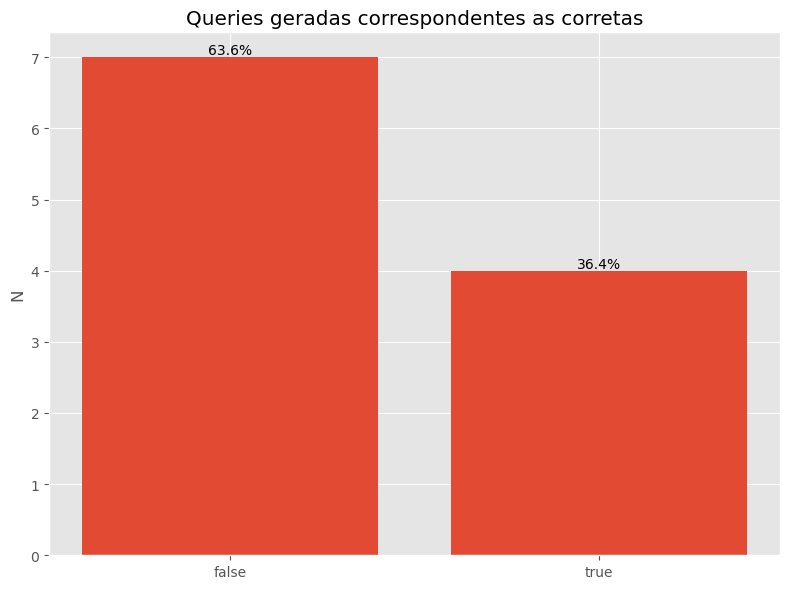

In [113]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

value_counts = df.auditor_answer.value_counts()
percentages = df.auditor_answer.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values)

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%',
             ha='center', va='bottom')


plt.title('Queries geradas correspondentes as corretas')
# plt.xlabel('Corret')
plt.ylabel('N')
plt.tight_layout()

plt.show()

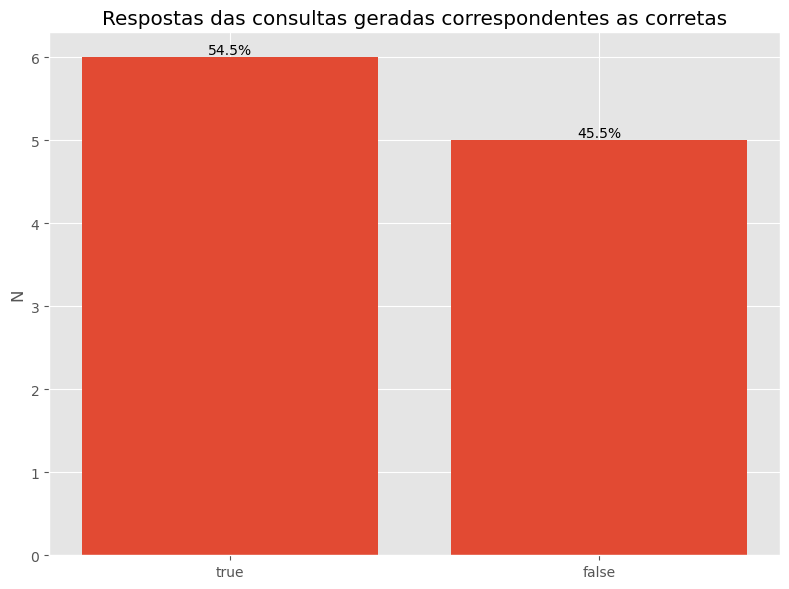

In [114]:
value_counts = df.auditor_query_results_answer.value_counts()
percentages = df.auditor_query_results_answer.value_counts(normalize=True) * 100


plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values)

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%',
             ha='center', va='bottom')


plt.title('Respostas das consultas geradas correspondentes as corretas')
# plt.xlabel('Corret')
plt.ylabel('N')
plt.tight_layout()

plt.show()